In [1]:
from scipy import stats
import random

Functions

In [2]:
def safediv(n, d):
    return n/d if d!=0 else np.nan

def between(array, minv, maxv):
    return [v>=minv and v<maxv for v in array]

def get_overlap(df, close, svars):
    ser = pd.Series([safediv(sum(df[v].between(0,close)), 
                             sum(df[v].between(0,1e10))) 
                     for v in svars])
    ser.index = svars
    counts = pd.Series([len(df)], index=["counts"])
    #ser = ser.append(counts)
    return ser

Read data

In [11]:
c = pd.read_csv("../results/crossover.closeshuf.full.tab.gz", sep="\t", header=None)
c.columns = ["scaf", "start", "end", "cross_id", "cpgi", "prdm9", "hotspot","rep", "fam", "allele"]
with open("../misc_files/crossids_nonhot.txt","r") as fh:
    nonhot = [line.strip() for line in fh]

In [15]:
lec = c.groupby("cross_id").count()
c = c[~c.cross_id.isin(list(lec[lec.scaf!=796].index))]

Parental chromosome where the crossover happened & chromosome types

In [16]:
ctypes = pd.read_csv("../corn_macro_micro_dnazoo.tab",sep="\t").set_index("scaf")["nature"].to_dict()
c["ctype"] = [ctypes[scaf] if scaf in ctypes else "unk" for scaf in c.scaf]

c2p = pd.read_csv("../misc_files/crossover2parent.tab",sep="\t",header=None).set_index(0)[1].to_dict()
c["parent"] = [c2p[cross_id] for cross_id in c.cross_id]

Whole families

In [132]:
#c["comb"] = c.parent + "_" + c.fam + "_" + c.allele
#sel_rounds = ["M_fam1_I","M_"]
#c[c.comb.isin]

Crossovers with sufficient resolution

In [17]:
c["width"] = c.end - c.start
c = c[c.width.between(1, 5e3)].reset_index(drop=True)
#c = c[~c.cross_id.isin(nonhot)]
c = c[c.ctype!="unk"]

In [18]:
def compute_overlap(df, close, svars):
    ser = pd.Series([safediv(sum(df[v].between(0,close)), 
                             sum(df[v].between(0,1e10))) 
                     for v in svars])
    ser.index = svars
    counts = pd.Series([len(df)], index=["counts"])
    ser = ser.append(counts)
    return ser 

def get_perc_from_overlaps(df, svars):
    return pd.Series([stats.percentileofscore(df[v].values[1:], df[v].values[0]) for v in svars], index=svars)

def get_perc_og_conditional(df, close, far, svars, perc_bool):
    
    cond_dist_pairing = {"cpgi":"prdm9", 
                         "prdm9":"cpgi", 
                         "hotspot":"cpgi"}
    
    # No condition on distance to other feature
    results = []
    ecdfs = []
    for v in svars:
        for cond in [False, True]:
            if cond==False:
                sdf = df
            elif cond==True:
                cond_v = cond_dist_pairing[v]
                og_df  = df[df.rep==0]
                keep_ids = og_df[og_df[cond_v]>=far].cross_id.unique()
                sdf = df[df.cross_id.isin(keep_ids)]
            cond_str = "all" if cond==False else "far_from_{}".format(cond_v)
            og_v = []
            shuf_v = []
            for rep,ssdf in sdf.groupby("rep"):
                counts = len(ssdf)
                frac_overlap = safediv(sum(ssdf[v].between(0,close)), 
                                       sum(ssdf[v].between(0,1e10)))
                ecdfs.append([rep, frac_overlap, v, cond_str, counts])
                if rep==0:
                    og_v.append(frac_overlap)
                else:
                    shuf_v.append(frac_overlap)
            
            if len(og_v)!=0:
                perc = stats.percentileofscore(shuf_v, og_v)[0]
            else:
                perc = np.nan
                counts = 0
            results.append([counts, perc, v, cond_str])

    if perc_bool:
        results_df = pd.DataFrame(results)
        results_df.columns = ["counts", "percentile", "feature", "cond"]
        return results_df
    if not perc_bool:
        ecdfs_df = pd.DataFrame(ecdfs)
        ecdfs_df.columns = ["rep", "frac_overlap", "feature", "cond", "counts"]
        return ecdfs_df

close = 1
far = 5e3
svars = ["cpgi", "prdm9"]
group_vars = ["fam", "allele", "ctype", "parent"]
percs = c.groupby(group_vars).apply(lambda x: get_perc_og_conditional(df=x, 
                                                                      close=close, 
                                                                      far=far, 
                                                                      svars=svars, 
                                                                      perc_bool=True)).reset_index()
percs["col"] = ["{}|{}".format(r.fam, r.parent) for i,r in percs.iterrows()]
ecdfs = c.groupby(group_vars).apply(lambda x: get_perc_og_conditional(df=x, 
                                                                      close=close, 
                                                                      far=far, 
                                                                      svars=svars, 
                                                                      perc_bool=False)).reset_index()
ecdfs["col"] = ["{}|{}".format(r.fam, r.parent) for i,r in ecdfs.iterrows()]

ecdfs:

In [19]:
def shuf_ecdfplot(x, **kwargs):
    v = list(x)
    sns.ecdfplot(v[1:], **kwargs)
def og_avline(x, **kwargs):
    v = list(x)
    plt.axvline(x=v[0], **kwargs)
def annotate_perc(x, **kwargs):
    v = list(x)
    og = v[0]
    shuf = v[1:]
    perc = stats.percentileofscore(shuf, og)
    plt.annotate("{:.1f}th".format(perc), xy=(og, random.uniform(0,1)), **kwargs)

In [ ]:
for (allele, col),df in ecdfs.groupby(["allele", "col"]):
    df["second_row"] = ["{}_cond".format(r.feature) if r.cond!="all" else r.feature for i,r in df.iterrows()]
    g = sns.FacetGrid(data=df, row="second_row", col="ctype")
    g.map(shuf_ecdfplot, "frac_overlap", linestyle="dotted")
    g.map(og_avline, "frac_overlap", linewidth=1)
    g.map(annotate_perc, "frac_overlap")
    g.set_titles(row_template = '{row_name}', 
             col_template = '{col_name}')
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('{}, {}'.format(col, allele), fontsize=10)
    g.set_axis_labels("Fraction overlap with feature", 
                  "Cumulative proportion of\nshuffled crossovers")
    g.tight_layout()
    g.savefig("pdfs/{}_{}.pdf".format(col, allele))
    plt.close()

Percentiles:

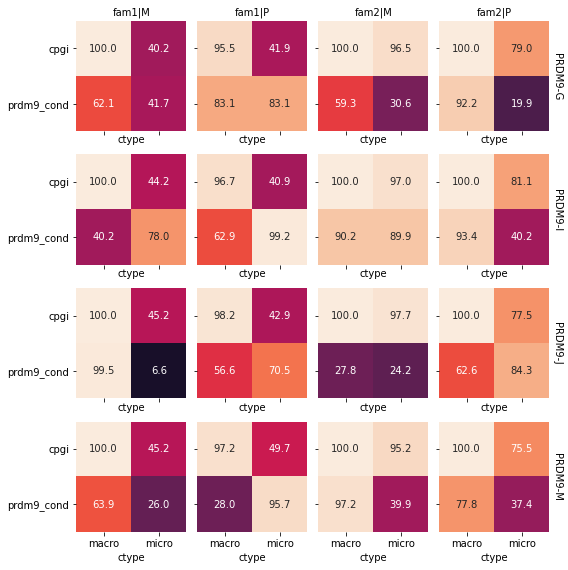

In [20]:
percs["comb"] = percs.feature + "_" + percs.cond
sel_percs = percs[(percs.comb.isin(['cpgi_all', 'prdm9_far_from_cpgi'])) & (percs.allele.str.contains("PRDM"))]

g = sns.FacetGrid(data=sel_percs, 
                  row="allele", col="col", 
                  margin_titles=True, 
                  height=2, aspect=1)

z = "percentile"

for (allele, col),ax in g.axes_dict.items():
    subd = sel_percs[(sel_percs.col==col) & 
                     (sel_percs.allele==allele)]
    og = subd[subd.cond=="all"].pivot(index="feature", columns="ctype", values=z)
    cond = subd[subd.cond!="all"].pivot(index="feature", columns="ctype", values=z)
    cond.index = ["{}_cond".format(i) for i in cond.index]
    ssubd = pd.concat([og, cond])
    ssubd = ssubd.sort_index(level=sorted(list(ssubd.index)))
    sns.heatmap(ssubd, 
                annot=True, fmt='.1f',
                cbar = False,
                vmin=0, vmax=100,
                square=True, 
                ax=ax)
    ax.set_yticklabels(labels=list(ssubd.index),rotation=0) 


g.set_titles(row_template = '{row_name}', 
             col_template = '{col_name}')
g.tight_layout()
#g.savefig("pdfs/percentile_combinations_hotspotPWMs.pdf")

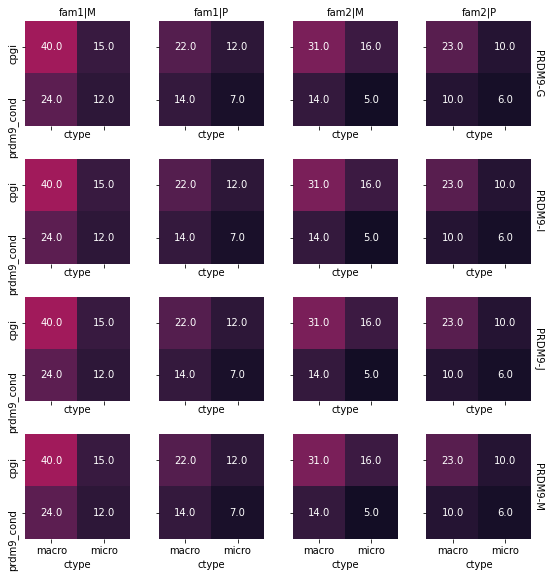

In [95]:
percs["comb"] = percs.feature + "_" + percs.cond
sel_percs = percs[(percs.comb.isin(['cpgi_all', 'prdm9_far_from_cpgi'])) & (percs.allele.str.contains("PRDM"))]

g = sns.FacetGrid(data=sel_percs, 
                  row="allele", col="col", 
                  margin_titles=True, 
                  height=2, aspect=1)

z = "counts"

for (allele, col),ax in g.axes_dict.items():
    subd = sel_percs[(sel_percs.col==col) & 
                     (sel_percs.allele==allele)]
    og = subd[subd.cond=="all"].pivot(index="feature", columns="ctype", values=z)
    cond = subd[subd.cond!="all"].pivot(index="feature", columns="ctype", values=z)
    cond.index = ["{}_cond".format(i) for i in cond.index]
    ssubd = pd.concat([og, cond])
    ssubd = ssubd.sort_index(level=sorted(list(ssubd.index)))
    sns.heatmap(ssubd, 
                annot=True, fmt='.1f',
                cbar = False,
                vmin=0, vmax=100,
                square=True, 
                ax=ax)

g.set_titles(row_template = '{row_name}', 
             col_template = '{col_name}')
g.tight_layout()
#g.savefig("pdfs/counts_combinations.pdf")

Previous code

In [38]:
cond_dist_pairing = {"cpgi":"prdm9", 
                     "prdm9":"cpgi", 
                     "hotspot":"cpgi"}

og_d = c[c.rep==0]

for v in svars:
    cond_dist = cond_dist_pairing[v]
    keep_ids = og_d[og_d[cond_dist]>=far].cross_id.unique()
    selc = c[c.cross_id.isin(keep_ids)]
    cond_res = selc.groupby(group_vars).apply(lambda x: get_overlap(df=x, 
                                                                    close=close, 
                                                                    svars=svars))
    cond_res = cond_res.reset_index()
    overlap["{}_far_from_{}".format(v, cond_dist)] = cond_res[v]
    overlap["counts_far_from_{}".format(cond_dist)] = cond_res["counts"]
    print(v)

NameError: name 'overlap' is not defined

Get count of crossovers in each condition

In [189]:
overlap

,fam,rep,allele,ctype,parent,cpgi,prdm9,counts,cpgi_far_from_prdm9,counts_far_from_prdm9,prdm9_far_from_cpgi,counts_far_from_cpgi
0,fam1,0,PRDM9-G,macro,M,0.270270,0.054054,37.0,0.270270,37.0,0.043478,23.0
1,fam1,0,PRDM9-G,macro,P,0.190476,0.142857,21.0,0.190476,21.0,0.142857,14.0
2,fam1,0,PRDM9-G,micro,M,0.071429,0.000000,14.0,0.071429,14.0,0.000000,11.0
3,fam1,0,PRDM9-G,micro,P,0.100000,0.200000,10.0,0.111111,9.0,0.166667,6.0
4,fam1,0,PRDM9-I,macro,M,0.270270,0.027027,37.0,0.270270,37.0,0.043478,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4747,fam2,99,fam1,micro,P,0.000000,0.100000,10.0,0.000000,8.0,0.166667,6.0
4748,fam2,99,fam2,macro,M,0.035714,0.107143,28.0,0.035714,28.0,0.142857,14.0
4749,fam2,99,fam2,macro,P,0.130435,0.086957,23.0,0.136364,22.0,0.200000,10.0
4750,fam2,99,fam2,micro,M,0.062500,0.125000,16.0,0.062500,16.0,0.200000,5.0


In [135]:
group_vars_norep = [v for v in group_vars if v!="rep"]
comp_svars = overlap.columns[len(group_vars):]

percs = []

for gvar,df in overlap.groupby(group_vars_norep):
    og_df = df[df.rep==0]
    shuf_df = df[df.rep!=0]
    for v in comp_svars:
        perc = stats.percentileofscore(shuf_df[v], 
                                       og_df[v])
        percs.append(list(gvar) + list(perc))
        

In [116]:
def get_percentile(df, svars):
    og_df = df[df.rep==0]
    shuf_df = df[df.rep!=0]
    for v in svars:
        og = v[0]
        shuf = v[1:]
    perc = stats.percentileofscore(shuf, og)

,fam,rep,allele,ctype,parent,cpgi,prdm9,cpgi_far_from_prdm9,prdm9_far_from_cpgi
2399,fam2,0,fam2,micro,P,0.2,0.2,0.250,0.166667
2423,fam2,2,fam2,micro,P,0.1,0.1,0.125,0.166667
2447,fam2,3,fam2,micro,P,0.2,0.3,0.125,0.333333
2471,fam2,4,fam2,micro,P,0.2,0.1,0.250,0.166667
2495,fam2,5,fam2,micro,P,0.1,0.2,0.125,0.166667
...,...,...,...,...,...,...,...,...,...
4655,fam2,95,fam2,micro,P,0.0,0.2,0.000,0.166667
4679,fam2,96,fam2,micro,P,0.1,0.0,0.000,0.000000
4703,fam2,97,fam2,micro,P,0.3,0.0,0.250,0.000000
4727,fam2,98,fam2,micro,P,0.1,0.2,0.125,0.000000


Plotting with ecdfs

In [65]:
def shuf_ecdfplot(x, **kwargs):
    v = list(x)
    sns.ecdfplot(v[1:], **kwargs)
def og_avline(x, **kwargs):
    v = list(x)
    plt.axvline(x=v[0], **kwargs)
def annotate_perc(x, **kwargs):
    v = list(x)
    og = v[0]
    shuf = v[1:]
    perc = stats.percentileofscore(shuf, og)
    plt.annotate("{:.1f}th".format(perc), xy=(og, random.uniform(0,1)), **kwargs)

In [ ]:
sq_overlap = overlap.melt(id_vars=group_vars, value_vars = overlap.columns[len(group_vars):])

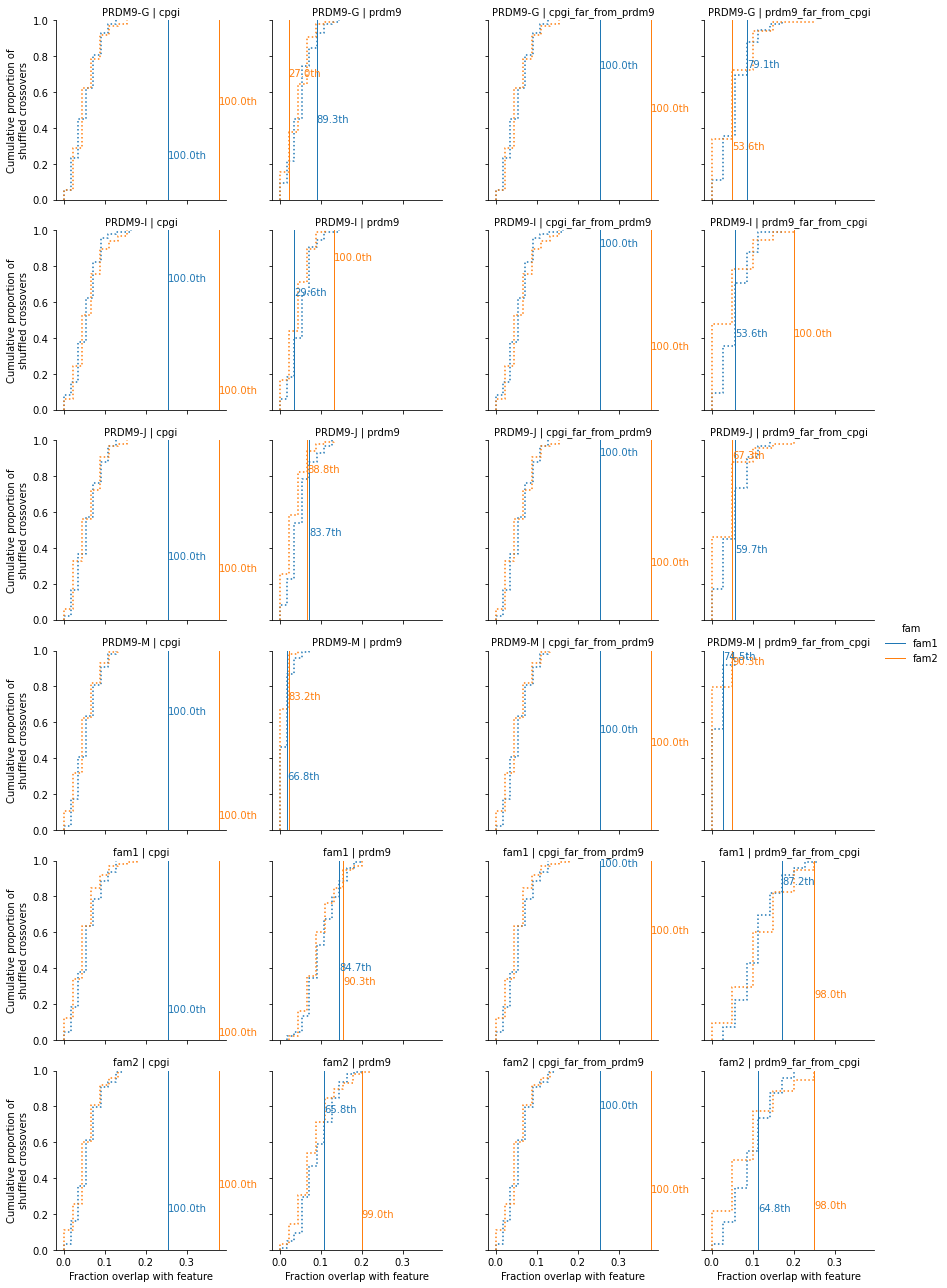

In [84]:
g = sns.FacetGrid(data=sq_overlap[sq_overlap.ctype=="macro"], col="variable", row="allele", hue="fam")
g.map(shuf_ecdfplot, "value", linestyle="dotted")
g.map(og_avline, "value", linewidth=1)
g.map(annotate_perc, "value")
g.set_titles(row_template = '{row_name}', 
             col_template = '{col_name}')
g.tight_layout()
g.set_axis_labels("Fraction overlap with feature", 
                  "Cumulative proportion of\nshuffled crossovers")
g.add_legend()
#g.savefig("pdfs/overlaps_famhotspots.pdf")

Repeats

In [65]:
l = []
for f in ["fam1","fam2"]:
    df = pd.read_csv("../repeat_overlap/{}.bed".format(f), sep="\t", header=None)
    df.columns = ["scaf", "start", "end", "parent", "frac_rmsk", "frac_gap", "rep"]
    df["nature"] = ["original" if rep==0 else "shuffled" for rep in df.rep]
    l.append(df)
r = pd.concat(l)
r["width"] = r.end-r.start

In [66]:
r.groupby("rep")["frac_rmsk"].median()

rep
0      0.516642
1      0.525504
2      0.511853
3      0.564103
4      0.528405
         ...   
96     0.485510
97     0.551702
98     0.569839
99     0.542160
100    0.502924
Name: frac_rmsk, Length: 101, dtype: float64

<AxesSubplot:xlabel='rep', ylabel='frac_rmsk'>

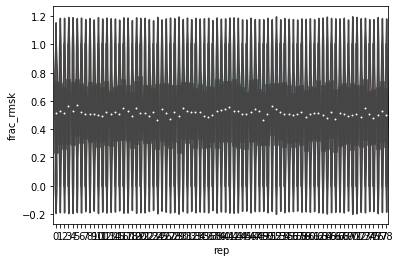

In [26]:
sns.violinplot(data=r, x="rep", y="frac_rmsk")